<a href="https://colab.research.google.com/github/beercafeguy/SparkML/blob/master/regression/pyspark_with_colab_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
!ls -ltr

total 223372
drwxr-xr-x 13 1000 1000      4096 Feb 22  2021 spark-3.1.1-bin-hadoop3.2
-rw-r--r--  1 root root 228721937 Feb 22  2021 spark-3.1.1-bin-hadoop3.2.tgz
drwxr-xr-x  1 root root      4096 Aug  3 13:45 sample_data


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [5]:
!wget https://jacobceles.github.io/knowledge_repo/colab_and_pyspark/cars.csv

--2023-08-06 11:11:10--  https://jacobceles.github.io/knowledge_repo/colab_and_pyspark/cars.csv
Resolving jacobceles.github.io (jacobceles.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to jacobceles.github.io (jacobceles.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://jacobcelestine.com/knowledge_repo/colab_and_pyspark/cars.csv [following]
--2023-08-06 11:11:10--  https://jacobcelestine.com/knowledge_repo/colab_and_pyspark/cars.csv
Resolving jacobcelestine.com (jacobcelestine.com)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to jacobcelestine.com (jacobcelestine.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22608 (22K) [text/csv]
Saving to: ‘cars.csv’

cars.csv            100%[===================>]  22.08K  --.-KB/s    in 0s      

2023-08-06 11:11:10 (152 MB/s) - ‘cars.csv’ saved [22608/22608]



In [6]:
!ls -ltr

total 223396
drwxr-xr-x 13 1000 1000      4096 Feb 22  2021 spark-3.1.1-bin-hadoop3.2
-rw-r--r--  1 root root 228721937 Feb 22  2021 spark-3.1.1-bin-hadoop3.2.tgz
-rw-r--r--  1 root root     22608 Apr 16 22:03 cars.csv
drwxr-xr-x  1 root root      4096 Aug  3 13:45 sample_data


In [7]:
spark

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
from pyspark.sql import functions as F
path = '/content/drive/MyDrive/ML_A_Z/Part_3_Classification/Section_18_Naive_Bayes/Python/Social_Network_Ads.csv'
df = (
    spark.read.option('header','true').csv(path)
    .withColumn('Age',F.col('Age').cast('int'))
    .withColumn('EstimatedSalary',F.col('EstimatedSalary').cast('double'))
    .withColumn('Purchased',F.col('Purchased').cast('int'))
)

In [27]:
df.show()

+---+---------------+---------+
|Age|EstimatedSalary|Purchased|
+---+---------------+---------+
| 19|        19000.0|        0|
| 35|        20000.0|        0|
| 26|        43000.0|        0|
| 27|        57000.0|        0|
| 19|        76000.0|        0|
| 27|        58000.0|        0|
| 27|        84000.0|        0|
| 32|       150000.0|        1|
| 25|        33000.0|        0|
| 35|        65000.0|        0|
| 26|        80000.0|        0|
| 26|        52000.0|        0|
| 20|        86000.0|        0|
| 32|        18000.0|        0|
| 18|        82000.0|        0|
| 29|        80000.0|        0|
| 47|        25000.0|        1|
| 45|        26000.0|        1|
| 46|        28000.0|        1|
| 48|        29000.0|        1|
+---+---------------+---------+
only showing top 20 rows



In [28]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Age,400,37.655,10.482876597307927,18,60
EstimatedSalary,400,69742.5,34096.9602824248,15000.0,150000.0
Purchased,400,0.3575,0.4798639635968691,0,1


<Axes: >

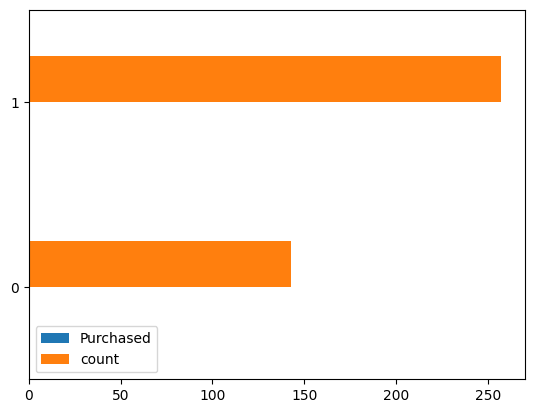

In [29]:
df.groupBy('Purchased').count().toPandas().plot(kind='barh')

In [30]:
df.toPandas().isnull().sum()

Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [31]:
# counting null in columns in pyspark

from pyspark.sql import functions as F
df.select([F.count(F.when(F.isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,Age,EstimatedSalary,Purchased
0,0,0,0


In [32]:
from pyspark.ml.feature import VectorAssembler


In [33]:
feat_cols = ['Age','EstimatedSalary']
label_col = 'Purchased'

In [34]:
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Purchased: integer (nullable = true)



In [35]:
assembler = VectorAssembler(inputCols = feat_cols,outputCol="vectorized_features")
assembler_df = assembler.transform(df)
assembler_df.show()

+---+---------------+---------+-------------------+
|Age|EstimatedSalary|Purchased|vectorized_features|
+---+---------------+---------+-------------------+
| 19|        19000.0|        0|     [19.0,19000.0]|
| 35|        20000.0|        0|     [35.0,20000.0]|
| 26|        43000.0|        0|     [26.0,43000.0]|
| 27|        57000.0|        0|     [27.0,57000.0]|
| 19|        76000.0|        0|     [19.0,76000.0]|
| 27|        58000.0|        0|     [27.0,58000.0]|
| 27|        84000.0|        0|     [27.0,84000.0]|
| 32|       150000.0|        1|    [32.0,150000.0]|
| 25|        33000.0|        0|     [25.0,33000.0]|
| 35|        65000.0|        0|     [35.0,65000.0]|
| 26|        80000.0|        0|     [26.0,80000.0]|
| 26|        52000.0|        0|     [26.0,52000.0]|
| 20|        86000.0|        0|     [20.0,86000.0]|
| 32|        18000.0|        0|     [32.0,18000.0]|
| 18|        82000.0|        0|     [18.0,82000.0]|
| 29|        80000.0|        0|     [29.0,80000.0]|
| 47|       

In [37]:
from pyspark.ml.feature import StandardScaler
sc = StandardScaler().setInputCol("vectorized_features").setOutputCol("features")
sc_model = sc.fit(assembler_df)
scaled_df = sc_model.transform(assembler_df)
scaled_df.show(truncate=False)

+---+---------------+---------+-------------------+---------------------------------------+
|Age|EstimatedSalary|Purchased|vectorized_features|features                               |
+---+---------------+---------+-------------------+---------------------------------------+
|19 |19000.0        |0        |[19.0,19000.0]     |[1.8124796017229972,0.5572344233217031]|
|35 |20000.0        |0        |[35.0,20000.0]     |[3.338778213700258,0.5865625508649507] |
|26 |43000.0        |0        |[26.0,43000.0]     |[2.480235244463049,1.261109484359644]  |
|27 |57000.0        |0        |[27.0,57000.0]     |[2.5756289077116277,1.6717032699651093]|
|19 |76000.0        |0        |[19.0,76000.0]     |[1.8124796017229972,2.2289376932868126]|
|27 |58000.0        |0        |[27.0,58000.0]     |[2.5756289077116277,1.7010313975083569]|
|27 |84000.0        |0        |[27.0,84000.0]     |[2.5756289077116277,2.463562713632793] |
|32 |150000.0       |1        |[32.0,150000.0]    |[3.0525972239545216,4.3992191

In [40]:
print(sc_model.mean)
print(sc_model.std)

[37.65499999999996,69742.50000000001]
[10.482876597307927,34096.9602824248]


In [43]:
from pyspark.ml import Pipeline

pipeline = Pipeline().setStages([assembler,sc])
pipeline_model = pipeline.fit(df)
pipeline_df = pipeline_model.transform(df)
pipeline_df.show(truncate=False)

+---+---------------+---------+-------------------+---------------------------------------+
|Age|EstimatedSalary|Purchased|vectorized_features|features                               |
+---+---------------+---------+-------------------+---------------------------------------+
|19 |19000.0        |0        |[19.0,19000.0]     |[1.8124796017229972,0.5572344233217031]|
|35 |20000.0        |0        |[35.0,20000.0]     |[3.338778213700258,0.5865625508649507] |
|26 |43000.0        |0        |[26.0,43000.0]     |[2.480235244463049,1.261109484359644]  |
|27 |57000.0        |0        |[27.0,57000.0]     |[2.5756289077116277,1.6717032699651093]|
|19 |76000.0        |0        |[19.0,76000.0]     |[1.8124796017229972,2.2289376932868126]|
|27 |58000.0        |0        |[27.0,58000.0]     |[2.5756289077116277,1.7010313975083569]|
|27 |84000.0        |0        |[27.0,84000.0]     |[2.5756289077116277,2.463562713632793] |
|32 |150000.0       |1        |[32.0,150000.0]    |[3.0525972239545216,4.3992191

In [44]:
train,test = pipeline_df.randomSplit([0.80,0.20],seed=2023)
print(train.count())
print(test.count())

319
81


In [45]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features",labelCol="Purchased",maxIter=5)
lr_model = lr.fit(train)

In [46]:
pred = lr_model.transform(test)

<Axes: >

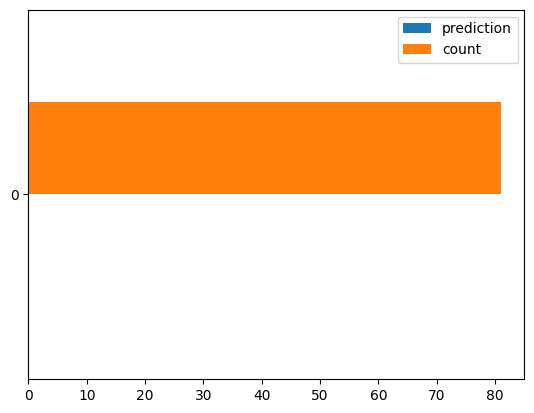

In [48]:
pred.groupBy('prediction').count().toPandas().plot(kind='barh')